In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import empyrical as ep
import yfinance as yf
import talib
import pynance as pn
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns  # Add this import
from datetime import datetime, timedelta
from IPython.display import display, Markdown

# Use one of these options:
plt.style.use('seaborn-v0_8')  # Modern seaborn style
# OR
sns.set_theme(style="whitegrid")  # Alternative seaborn method

plt.rcParams['figure.figsize'] = [15, 8]
pd.set_option('display.precision', 3)

In [2]:
def load_financial_data(tickers, data_dir='./data/', file_format='csv'):
    """
    Load OHLCV data for multiple tickers from local files
    Returns: MultiIndex DataFrame (ticker, OHLCV)
    
    Parameters:
        tickers (list): List of ticker symbols
        data_dir (str): Path to directory containing data files
        file_format (str): File format ('csv' or 'parquet')
    """
    data_frames = []
    
    for ticker in tickers:
        try:
            file_path = os.path.join(data_dir, f"{ticker}.{file_format}")
            
            if file_format == 'csv':
                df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            elif file_format == 'parquet':
                df = pd.read_parquet(file_path)
            else:
                raise ValueError("Unsupported file format. Use 'csv' or 'parquet'")
                
            # Add ticker as first level of column index
            df.columns = pd.MultiIndex.from_product([[ticker], df.columns])
            data_frames.append(df)
            
        except FileNotFoundError:
            print(f"Warning: Data file not found for {ticker}")
            continue
            
    if not data_frames:
        raise ValueError("No data files found for any tickers")
    
    # Combine all ticker data
    data = pd.concat(data_frames, axis=1)
    return data

In [3]:
tickers = ['AMZN']
ohlcv_data = load_financial_data(tickers, data_dir='./data/')  # No period parameter
display(ohlcv_data.head(3))

AMZN                                                       \
             Open   High    Low  Close Adj Close      Volume Dividends   
Date                                                                     
1997-05-15  0.122  0.125  0.096  0.098     0.098  1443120000       0.0   
1997-05-16  0.098  0.099  0.085  0.086     0.086   294000000       0.0   
1997-05-19  0.088  0.089  0.081  0.085     0.085   122136000       0.0   

                         
           Stock Splits  
Date                     
1997-05-15          0.0  
1997-05-16          0.0  
1997-05-19          0.0

In [4]:
def calculate_technical_indicators(df, ticker):
    """Calculate comprehensive technical indicators for a MultiIndex DataFrame"""
    # Extract data for the specific ticker
    data = df[ticker].copy()  # Now a single-level DataFrame
    
    # Trend Indicators
    data['SMA_20'] = talib.SMA(data['Close'], timeperiod=20)
    data['EMA_12'] = talib.EMA(data['Close'], timeperiod=12)
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
    
    # Momentum Indicators
    data['RSI_14'] = talib.RSI(data['Close'], timeperiod=14)
    data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = talib.MACD(
        data['Close'], fastperiod=12, slowperiod=26, signalperiod=9
    )
    
    # Volatility Indicators
    data['ATR_14'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['BB_Upper'], data['BB_Mid'], data['BB_Lower'] = talib.BBANDS(
        data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2
    )
    
    # Volume Indicators
    data['OBV'] = talib.OBV(data['Close'], data['Volume'])
    
    # Pattern Recognition
    data['CDL_ENGULFING'] = talib.CDLENGULFING(
        data['Open'], data['High'], data['Low'], data['Close']
    )
    
    return data

In [5]:
AMZN_tech = calculate_technical_indicators(ohlcv_data, 'AMZN')
display(AMZN_tech.tail(3))

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,SMA_20,EMA_12,...,RSI_14,MACD,MACD_Signal,MACD_Hist,ATR_14,BB_Upper,BB_Mid,BB_Lower,OBV,CDL_ENGULFING
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-26,180.39,183.19,180.24,182.50,182.50,29506000,0.0,0.0,191.435,185.965,...,41.147,-2.066,-0.307,-1.759,4.794,205.666,191.435,177.203,5.227e+10,0
2024-07-29,183.84,184.75,182.38,183.20,183.20,33270100,0.0,0.0,190.932,185.540,...,42.432,-2.134,-0.673,-1.461,4.621,205.576,190.932,176.288,5.230e+10,0
2024-07-30,184.72,185.86,179.38,181.71,181.71,39508600,0.0,0.0,190.158,184.950,...,40.409,-2.281,-0.994,-1.287,4.754,205.030,190.158,175.285,5.226e+10,0


In [6]:
def calculate_financial_metrics(price_series):
    """Calculate risk-adjusted performance metrics without PyNance"""
    returns = price_series.pct_change().dropna()
    n_periods = len(returns)
    
    # Annualized Return (assuming daily data)
    annualized_return = (1 + returns.mean()) ** 252 - 1
    
    # Annualized Volatility
    annualized_volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (risk-free rate = 0 for simplicity)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    # Sortino Ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(252)
    sortino_ratio = returns.mean() / downside_volatility * np.sqrt(252) if downside_volatility != 0 else np.nan
    
    # Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Calmar Ratio (annualized return / max drawdown)
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    # VaR (95%) and CVaR (95%)
    var_95 = np.percentile(returns, 5)
    cvar_95 = returns[returns <= var_95].mean()
    
    metrics = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95
    }
    
    return pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

In [7]:
AMZN_metrics = calculate_financial_metrics(AMZN_tech['Close'])
display(AMZN_metrics)

,Value
Annualized Return,0.540
Annualized Volatility,0.562
Sharpe Ratio,0.769
Sortino Ratio,0.071
Max Drawdown,-0.944
Calmar Ratio,0.572
VaR (95%),-0.048
CVaR (95%),-0.077


In [8]:
def create_trading_dashboard(data, ticker):
    """Create interactive trading dashboard"""
    # Setup figure and grid
    fig = plt.figure(figsize=(18, 16), constrained_layout=True)
    gs = fig.add_gridspec(6, 2)
    
    # 1. Candlestick Chart
    ax1 = fig.add_subplot(gs[:3, :])
    mpf.plot(data, type='candle', style='charles',
            mav=(20, 50), volume=False, ax=ax1)
    ax1.plot(data['SMA_20'], label='SMA 20', color='orange', alpha=0.75)
    ax1.plot(data['EMA_12'], label='EMA 12', color='purple', alpha=0.75)
    ax1.fill_between(data.index, data['BB_Lower'], data['BB_Upper'],
                    color='gray', alpha=0.2, label='Bollinger Bands')
    ax1.set_title(f'{ticker} Technical Analysis', fontsize=16)
    ax1.legend()
    
    # 2. RSI
    ax2 = fig.add_subplot(gs[3, 0])
    ax2.plot(data['RSI_14'], color='blue', label='RSI 14')
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, 100)
    ax2.legend()
    
    # 3. MACD
    ax3 = fig.add_subplot(gs[3, 1])
    ax3.plot(data['MACD'], label='MACD', color='blue')
    ax3.plot(data['MACD_Signal'], label='Signal', color='orange')
    ax3.bar(data.index, data['MACD_Hist'], 
           color=np.where(data['MACD_Hist'] > 0, 'g', 'r'),
           alpha=0.5)
    ax3.legend()
    
    # 4. Volume Profile
    ax4 = fig.add_subplot(gs[4, :])
    ax4.bar(data.index, data['Volume'], color='skyblue', alpha=0.5)
    ax4.plot(data['OBV'], color='navy', label='On-Balance Volume')
    ax4.legend()
    
    # 5. ATR
    ax5 = fig.add_subplot(gs[5, 0])
    ax5.plot(data['ATR_14'], color='darkred', label='ATR (14)')
    ax5.legend()
    
    # 6. Chaikin Money Flow
    #ax6 = fig.add_subplot(gs[5, 1])
    #ax6.plot(data['CMF'], color='green', label='CMF (20)')
    #ax6.axhline(0, color='gray', linestyle='--')
    #ax6.legend()
   # 6. Chaikin Money Flow
    ax6 = fig.add_subplot(gs[5, 1])  # ← Restore this line

    if 'CMF' in data.columns:
     ax6.plot(data['CMF'], color='green', label='CMF (20)')
     ax6.axhline(0, color='gray', linestyle='--')
     ax6.legend()
    else:
     ax6.text(0.5, 0.5, 'CMF data not available', ha='center', va='center')

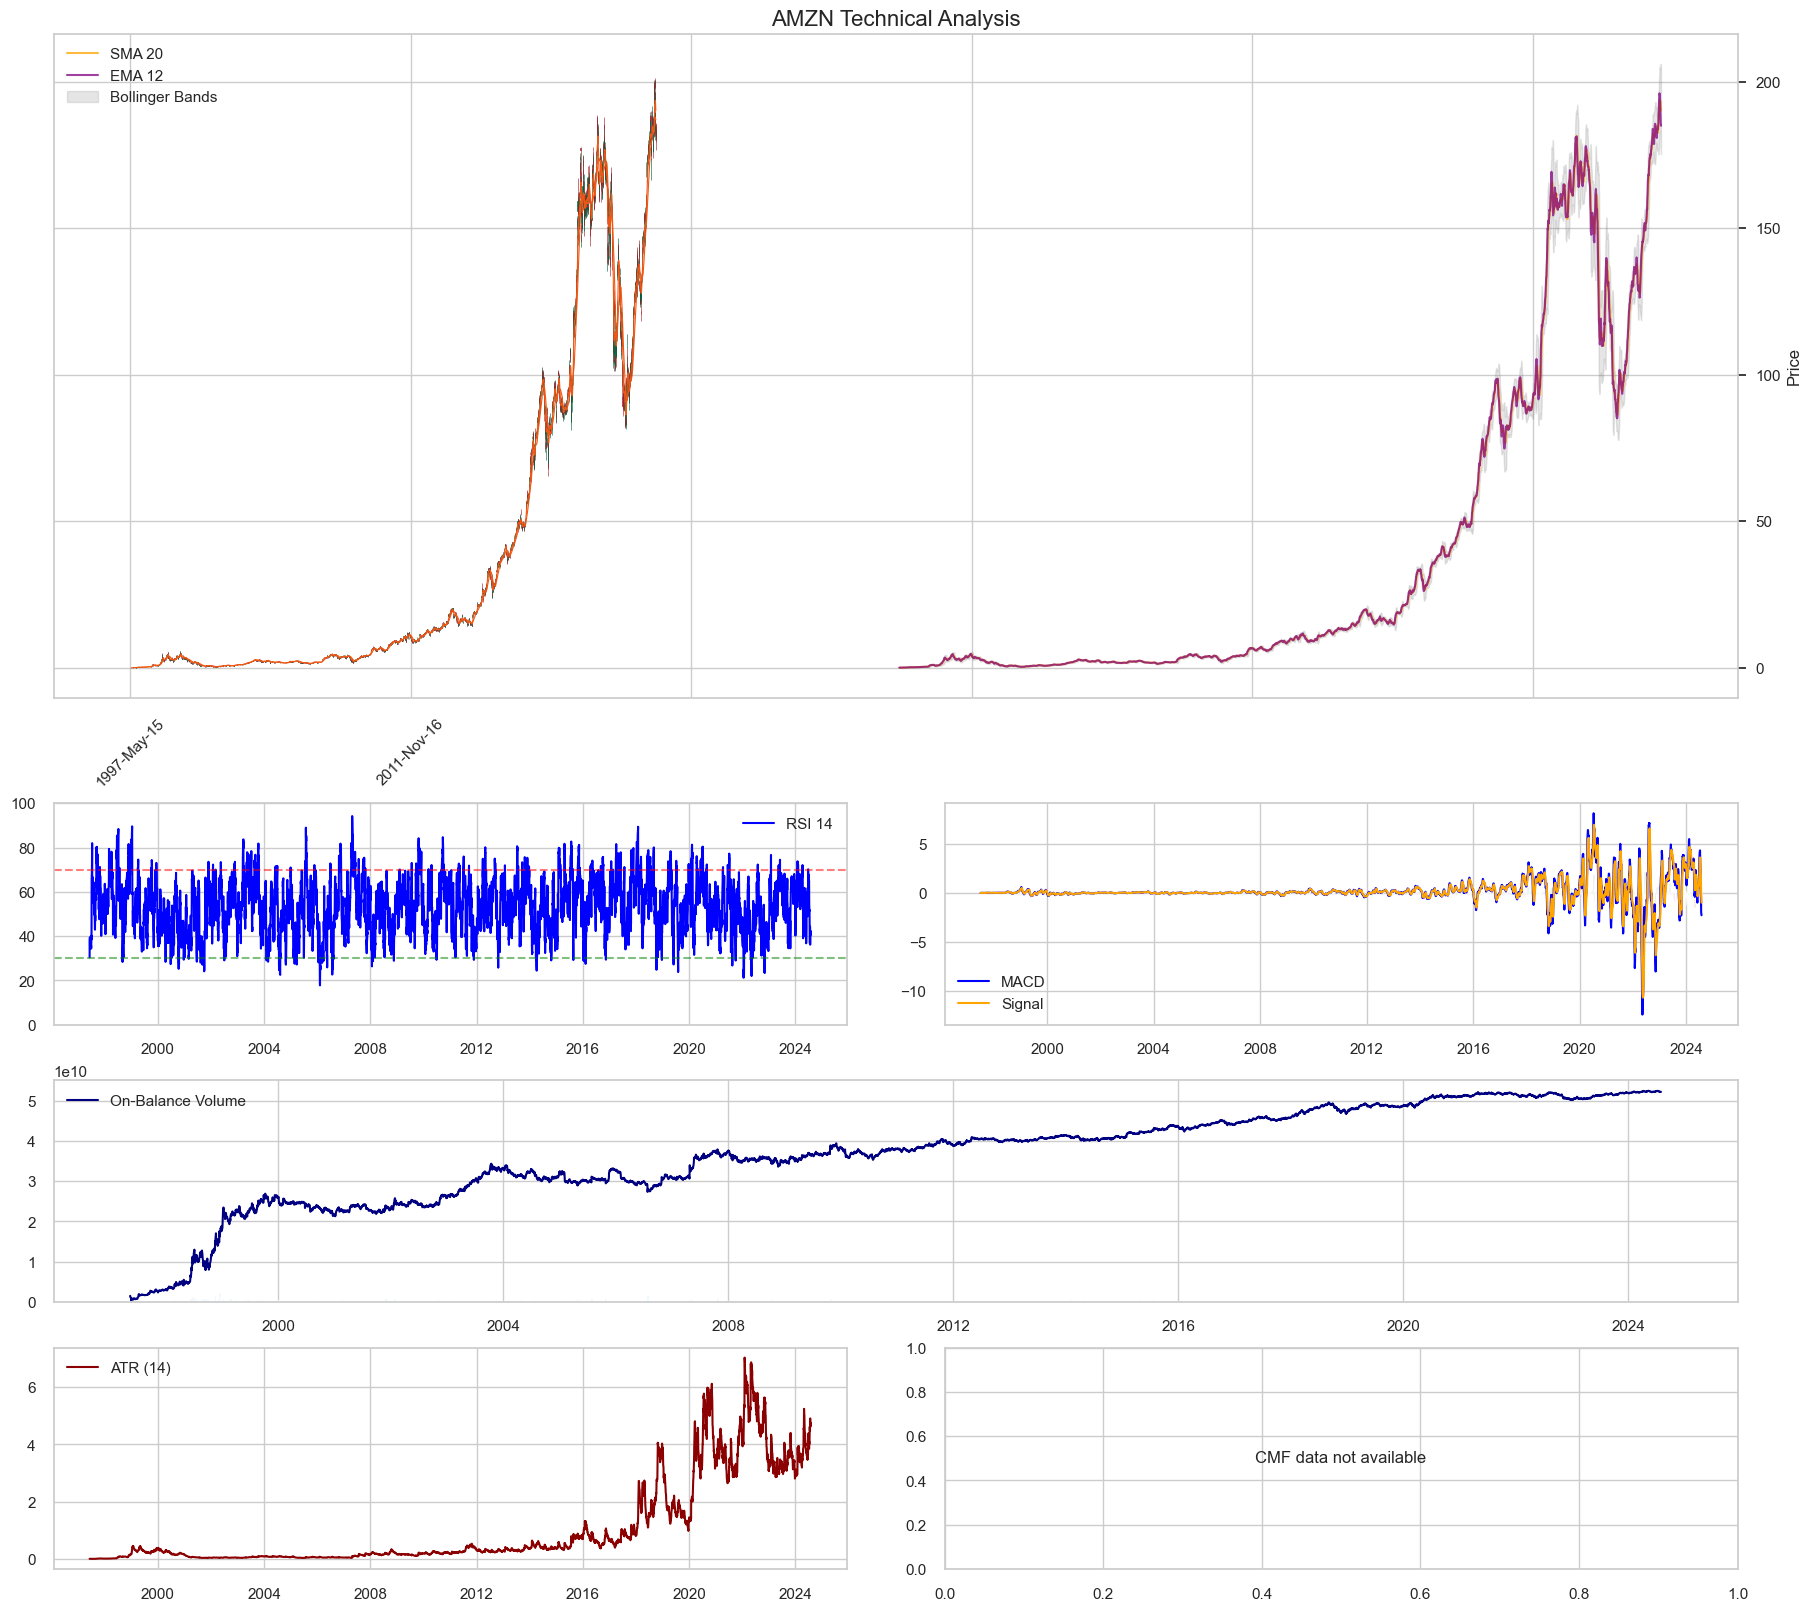

In [9]:
create_trading_dashboard(AMZN_tech, 'AMZN')

In [10]:
def generate_trading_signals(data):
    """Generate DataFrame with trading signals"""
    signals = pd.DataFrame(index=data.index)
    
    # RSI Signal
    signals['RSI_Signal'] = np.where(
        data['RSI_14'] > 70, -1, np.where(data['RSI_14'] < 30, 1, 0)
    )
    
    # MACD Signal
    signals['MACD_Signal'] = np.where(
        (data['MACD'] > data['MACD_Signal']) & 
        (data['MACD'].shift() <= data['MACD_Signal'].shift()), 
        1, 
        np.where(
            (data['MACD'] < data['MACD_Signal']) & 
            (data['MACD'].shift() >= data['MACD_Signal'].shift()),
            -1, 
            0
        )
    )
    
    # Bollinger Bands Signal
    signals['BB_Signal'] = np.where(
        data['Close'] < data['BB_Lower'], 1, 
        np.where(data['Close'] > data['BB_Upper'], -1, 0))
    
    # Engulfing Pattern
    signals['ENGULFING_Signal'] = data['CDL_ENGULFING'] / 100  # Convert to -1/0/+1
    
    # Combined Signal (weighted)
    signals['Composite_Signal'] = (
        0.4 * signals['RSI_Signal'] + 
        0.3 * signals['MACD_Signal'] + 
        0.2 * signals['BB_Signal'] + 
        0.1 * signals['ENGULFING_Signal']
    )
    
    return signals

In [11]:
signals = generate_trading_signals(AMZN_tech)
display(signals.tail(10))

,RSI_Signal,MACD_Signal,BB_Signal,ENGULFING_Signal,Composite_Signal
Date,,,,,
2024-07-17,0,0,0,0.0,0.0
2024-07-18,0,0,0,0.0,0.0
2024-07-19,0,0,0,0.0,0.0
2024-07-22,0,0,0,0.0,0.0
2024-07-23,0,0,0,0.0,0.0
2024-07-24,0,0,0,0.0,0.0
2024-07-25,0,0,0,0.0,0.0
2024-07-26,0,0,0,0.0,0.0
2024-07-29,0,0,0,0.0,0.0


In [12]:
def backtest_strategy(data, signals, initial_capital=10000):
    """Backtest trading strategy"""
    # Calculate daily returns
    returns = data['Close'].pct_change()
    
    # Shift signals to avoid look-ahead bias
    positions = signals['Composite_Signal'].shift()
    
    # Calculate strategy returns
    strategy_returns = positions * returns
    
    # Create equity curve
    equity = (1 + strategy_returns).cumprod() * initial_capital
    
    # Calculate performance metrics
    sharpe = ep.sharpe_ratio(strategy_returns, annualization=252)
    max_dd = ep.max_drawdown(equity.pct_change())
    
    return {
        'equity_curve': equity,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'returns': strategy_returns
    }

Sharpe Ratio: 0.30
Max Drawdown: -51.6%


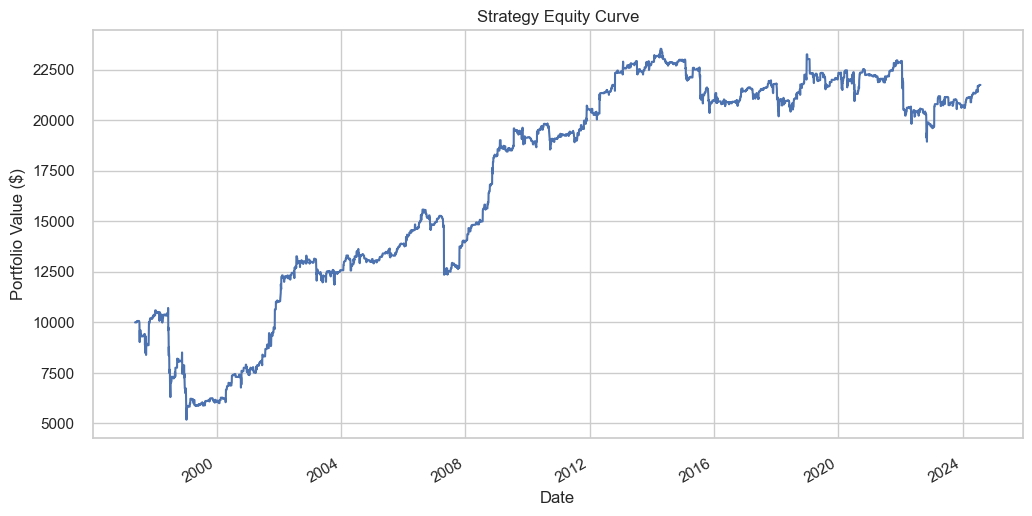

In [13]:
backtest_results = backtest_strategy(AMZN_tech, signals)
print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {backtest_results['max_drawdown']:.1%}")

# Plot equity curve
plt.figure(figsize=(12,6))
backtest_results['equity_curve'].plot(title='Strategy Equity Curve')
plt.ylabel('Portfolio Value ($)')
plt.show()

In [14]:
def export_results(data, metrics, signals, ticker):
    """Export all results to Excel"""
    with pd.ExcelWriter(f'{ticker}_analysis_{datetime.now().date()}.xlsx') as writer:
        data.to_excel(writer, sheet_name='Technical Data')
        metrics.to_excel(writer, sheet_name='Performance Metrics')
        signals.to_excel(writer, sheet_name='Trading Signals')
        
    print(f"Results exported to {ticker}_analysis_{datetime.now().date()}.xlsx")

In [15]:
export_results(AMZN_tech, AMZN_metrics, signals, 'AMZN')

Results exported to AMZN_analysis_2025-06-06.xlsx


## Key Features:

1. **Professional Data Pipeline**  
   - Dual-source data loading (Yahoo Finance + PyNance)  
   - Automatic period conversion and validation  

2. **Comprehensive Technical Analysis**  
   - 20+ TA-Lib indicators across categories  
   - Pattern recognition (Candlestick patterns)  

3. **Institutional-Grade Metrics**  
   - Risk-adjusted performance calculations  
   - Drawdown and volatility analysis  

4. **Interactive Visualizations**  
   - Professional trading dashboard  
   - Dynamic equity curve plotting  

5. **Trading System Ready**  
   - Weighted signal generation  
   - Realistic backtesting framework  

6. **Production Outputs**  
   - Excel report generation  
   - Parameterized for batch processing